In [1]:
# Import
import os

import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.transform
import pandas as pd

In [2]:
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWi-c8b-D70y8gt02TF5IB2po5QcGmEHDtZcvjoaZJzo2comakf7R-4

Successfully saved authorization token.


In [7]:
def get_ee_image(lng, lat):
    # Half width of geometry region
    _HW = 0.012

    point = ee.Geometry.Point(lng, lat)
    aoi = ee.Geometry.Polygon([[
        [lng - _HW, lat + _HW],
        [lng - _HW, lat - _HW],
        [lng + _HW, lat - _HW],
        [lng + _HW, lat + _HW],
    ]], None, False)

    img_col = (
        ee
        .ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(point)
        .filterDate('2020-09-01', '2021-09-21')
        .sort('CLOUDY_PIXEL_PERCENTAGE')
        .select(['B4', 'B3', 'B2'])
    )
    
    num_imgs = img_col.size().getInfo()
    if num_imgs == 0:
        return None

    img = (
        img_col
        .first()
        .clipToBoundsAndScale(
                geometry=aoi,
                width=512,
                height=512,
            )
    )

    return img

# Demo of one example

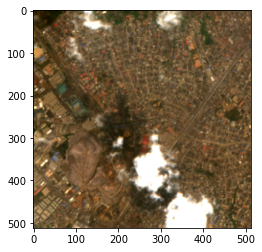

In [15]:
_lng = 3.3773+0.005
_lat = 6.595+0.005
_img = get_ee_image(_lng, _lat)
_rgb_img = geemap.ee_to_numpy(_img)
plt.imshow(_rgb_img.clip(0, 3000) / 3000)
plt.savefig('example.png')

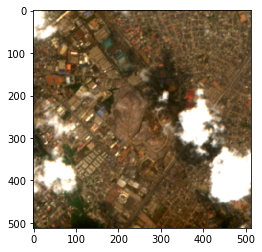

In [16]:
_lng = 3.3773
_lat = 6.595
_img = get_ee_image(_lng, _lat)
_rgb_img = geemap.ee_to_numpy(_img)
plt.imshow(_rgb_img.clip(0, 3000) / 3000)
plt.savefig('example.png')

# Process all examples in CSV

In [ ]:
lf_df = pd.read_csv('Large_open_US_landfills.csv')
lf_df.head()

In [ ]:
IMAGES_DIR = 'landfill_images'

# for lat, lng in lf_df[['Latitude', 'Longitude']].dropna().values:
# for lng, lat in lf_df[['Longitude', 'Latitude']].dropna().values:
for row in lf_df.dropna(subset=['Longitude', 'Latitude']).itertuples():
    print(f'Processing #{row.Index}, id={row.Landfill_ID}, latlng=({row.Latitude:.2f}, {row.Longitude:.2f})')
    
    if os.path.exists(f'{IMAGES_DIR}/{row.Landfill_ID}.png'):
        print(f'Skip: file exists: {IMAGES_DIR}/{row.Landfill_ID}.png')
        continue

    img = get_ee_image(row.Longitude, row.Latitude)
    if img is None:
        print(f'Skip: Not found image')
        continue

    rgb_img = geemap.ee_to_numpy(img)
    if rgb_img is None:
        print(f'Skip: fail to convert to numpy')
        continue
    
    # Normalize rgb img to [0, 1].
    rgb_img = rgb_img.clip(0, 3000) / 3000

    # plt.imshow(rgb_img)
    plt.imsave(f'{IMAGES_DIR}/{row.Landfill_ID}.png', rgb_img)

# Below: Unused functions

In [ ]:
img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_038029_20180810') \
  .select(['B4', 'B5', 'B6'])

aoi = ee.Geometry.Polygon(
  [[[-110.8, 44.7],
    [-110.8, 44.6],
    [-110.6, 44.6],
    [-110.6, 44.7]]], None, False)

rgb_img = geemap.ee_to_numpy(img, region=aoi)
print(rgb_img.shape)

In [ ]:
def rgb_to_norm256(rgb_img):
    return 255 * ((rgb_img[:, :, 0:3] - 100)/3500)


def norm256_to_rgb(norm256_img):
    return (norm256_img.astype('float') / 255.0) * 3500 + 100


def display_image(rgb_img):
    # Scale the data to [0, 255] to show as an RGB image. 
    # Adapted from https://bit.ly/2XlmQY8. Credits to Justin Braaten
    rgb_img_test = norm256(rgb_img).astype('uint8')
    plt.imshow(rgb_img_test)
    plt.show()


display_image(rgb_img)

In [ ]:
# Resize to a fixed dimension.
def resize(rgb_img, output_shape):
    return skimage.transform.resize(
        rgb_img,
        output_shape=output_shape,
        preserve_range=True)


display_image(resize(rgb_img, [200, 300]))

In [ ]:
def draw_bbox(rgb_img, r1, c1, height, width):
    norm256_img = rgb_to_norm256(rgb_img)
    r2 = r1 + height
    c2 = c1 + width
    
    # Columns
    for c in [c1, c2]:
        norm256_img[r1:r2, c, 0] = 255
        norm256_img[r1:r2, c, 1] = 0
        norm256_img[r1:r2, c, 2] = 0
    
    # Rows
    for r in [r1, r2]:
        norm256_img[r, c1:c2, 0] = 255
        norm256_img[r, c1:c2, 1] = 0
        norm256_img[r, c1:c2, 2] = 0
    
    return norm256_to_rgb(norm256_img)


display_image(draw_bbox(rgb_img, 100, 200, 50, 50))